In [1]:
from functools import partial
from pathlib import Path
from typing import Any

import colorcet as cc
import diffrax as dfx
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial as scspatial
from dynamical_systems.continuous import AbstractODE, Lorenz63, solve_ode, TangentODE
from dynamical_systems.transforms import TransformedODE
from dynamics_discovery.custom_types import FloatScalar
from dynamics_discovery.data import TimeSeriesDataset
from dynamics_discovery.data.loaders import (
    MiniBatching,
    RandomSampleBatching,
)
from dynamics_discovery.loss_functions import AbstractDynamicsLoss
from dynamics_discovery.models import NeuralODE, ODEModel
from dynamics_discovery.models.abstract import AbstractDynamicsModel
from dynamics_discovery.neighborhood import (
    NeighborhoodMSELoss,
    NeighborhoodSegmentLoader,
    NeuralNeighborhoodFlow,
)
from einops import rearrange
from jaxtyping import Array, Float, PyTree
from matplotlib_utils.plots import colored_scatterplot
from ott.utils import batched_vmap
from tqdm import tqdm


jax.config.update("jax_default_device", jax.devices("gpu")[2])
jax.config.update("jax_enable_x64", True)
plt.style.use("matplotlib_utils.styles.dash_gridded")

datadir = Path("../../data")

Consider a state vector $\boldsymbol{x}\in \mathbb{R}^d$ whose dynamics is governed by the ODE
\begin{equation}
\frac{d\boldsymbol{x}}{dt} = f(\boldsymbol{x}).
\end{equation}

The evolution of small deviations $\boldsymbol{\delta x}(t) \in \mathbb{R}^d$ around $\boldsymbol{x}(t)$ is described by the variational equation:
\begin{equation}
\frac{d\boldsymbol{\delta x}}{dt} = \nabla_{\boldsymbol{x}}f(\boldsymbol{x}(t))\boldsymbol{\delta x} = J(\boldsymbol{x})\boldsymbol{\delta x}.
\end{equation}

As this equation is linear with respect to $\boldsymbol{\delta x}$, we can instead consider the following matrix differential equation
\begin{equation}
\frac{d\boldsymbol{M}}{dt} = J(\boldsymbol{x})\boldsymbol{M}, \; \boldsymbol{M}(t=0) = \boldsymbol{I}
\end{equation}
where $\boldsymbol{M}(t;\boldsymbol{x})\in \mathbb{R}^{d\times d}$ is the tangent evolution matrix (or operator), and $\boldsymbol{I}$ is the $d\times d$ identity matrix.

In the vincinity of $\boldsymbol{x}(t)$, the tangent evolution matrix linearly maps the perturbations forward in time:
\begin{equation}
\boldsymbol{\delta x}(t+\tau) = \boldsymbol{M}(\tau;\boldsymbol{x}(t))\boldsymbol{\delta x}(t).
\end{equation}

Thus, when the number of deviations to forecast $m$ is larger than $d$, it is more economical to compute the tangent evolution matrix instead of directly solving the variational equation for the individual perturbations.

In [2]:
noise = 0.05
downsample = 2
dataset, transform = (
    TimeSeriesDataset(
        *TimeSeriesDataset.from_hdf5(datadir / "lorenz63_large.hdf5")[::100]
    )
    .downsample(downsample)
    .split_along_time(500)[0]
    .add_noise(noise)
    .standardize()
)

lorenz_scaled = TransformedODE(Lorenz63(), transform)

dataset.u.shape

(50, 500, 3)

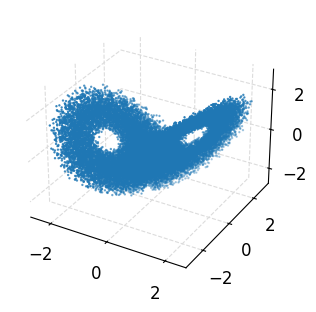

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3), subplot_kw={"projection": "3d"})
ax.scatter(*dataset.u.reshape(-1, 3).T, s=0.5)

## Find neighbors in the range $[r_{min}, r_{max}]$

In [4]:
r_min, r_max = 0.3, 0.5
rollout = 3

tree = scspatial.KDTree(
    rearrange(dataset.u[:, :-rollout], "traj time dim -> (traj time) dim")
)


distance_matrix = tree.sparse_distance_matrix(tree, r_max)
within_range = distance_matrix >= r_min

In [5]:
neighbor_inds = []
for i in tqdm(range(within_range.shape[0])):
    neighbor_inds.append(
        within_range.indices[within_range.indptr[i] : within_range.indptr[i + 1]]
    )

100%|██████████| 24850/24850 [00:00<00:00, 1120916.86it/s]


(array([  61.,  151.,  298.,  398.,  387.,  449.,  562.,  713.,  828.,
        1198., 1611., 1725., 1276., 1146., 1023.,  803.,  781.,  724.,
         697.,  574.,  457.,  461.,  476.,  407.,  371.,  349.,  318.,
         310.,  332.,  325.,  307.,  346.,  340.,  315.,  304.,  280.,
         320.,  311.,  335.,  363.,  289.,  322.,  295.,  271.,  317.,
         242.,  240.,  216.,  172.,   54.]),
 array([  16.  ,   50.96,   85.92,  120.88,  155.84,  190.8 ,  225.76,
         260.72,  295.68,  330.64,  365.6 ,  400.56,  435.52,  470.48,
         505.44,  540.4 ,  575.36,  610.32,  645.28,  680.24,  715.2 ,
         750.16,  785.12,  820.08,  855.04,  890.  ,  924.96,  959.92,
         994.88, 1029.84, 1064.8 , 1099.76, 1134.72, 1169.68, 1204.64,
        1239.6 , 1274.56, 1309.52, 1344.48, 1379.44, 1414.4 , 1449.36,
        1484.32, 1519.28, 1554.24, 1589.2 , 1624.16, 1659.12, 1694.08,
        1729.04, 1764.  ]),
 <BarContainer object of 50 artists>)

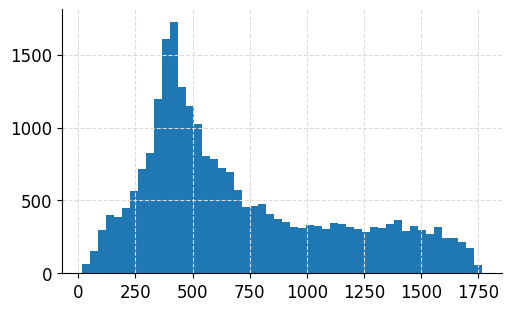

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.hist(np.asarray([len(idx) for idx in neighbor_inds]), bins=50)

In [7]:
def sample_neighbor_inds(
    sample_ind: int, n_samples: int, num_neighbor_cutoff: int = 30, key: int = 0
):
    rng = np.random.default_rng(key)
    low, high = within_range.indptr[sample_ind], within_range.indptr[sample_ind + 1]
    if high - low <= num_neighbor_cutoff:
        neighbor_inds = np.zeros_like(sample_ind, shape=(num_neighbors,))
        sufficient_neighbors = False
    else:
        ptrs = rng.integers(
            low,
            high,
            size=n_samples,
        )
        neighbor_inds = within_range.indices[ptrs]
        sufficient_neighbors = True
    return neighbor_inds, sufficient_neighbors

Sufficient number of neighbors present: True


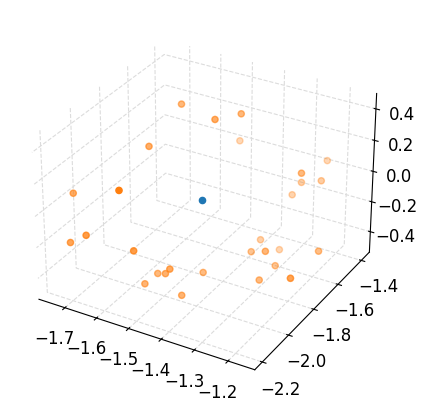

In [9]:
sample_ind = 50
neighbor_inds, sufficient = sample_neighbor_inds(sample_ind, 30, 0)
print(f"Sufficient number of neighbors present: {sufficient}")

fig, ax = plt.subplots(1, 1, figsize=(5, 4), subplot_kw={"projection": "3d"})

idx_center = np.divmod(sample_ind, dataset.u.shape[1] - rollout)
idx_neighbors = np.divmod(neighbor_inds, dataset.u.shape[1] - rollout)

ax.scatter(*dataset.u[idx_center].T)
ax.scatter(*dataset.u[idx_neighbors].T)

In [10]:
from dynamical_systems.transforms import TransformedODE
from dynamics_discovery.models import ODEModel
from dynamics_discovery.neighborhood import NeuralNeighborhoodFlow


model = ODEModel(TransformedODE(Lorenz63(), transform))
neighborflow = NeuralNeighborhoodFlow(model, second_order=True)

In [11]:
sol = neighborflow.solve(
    dataset.t[0, : rollout + 1],
    (dataset.u[idx_center], dataset.u[idx_neighbors] - dataset.u[idx_center]),
)

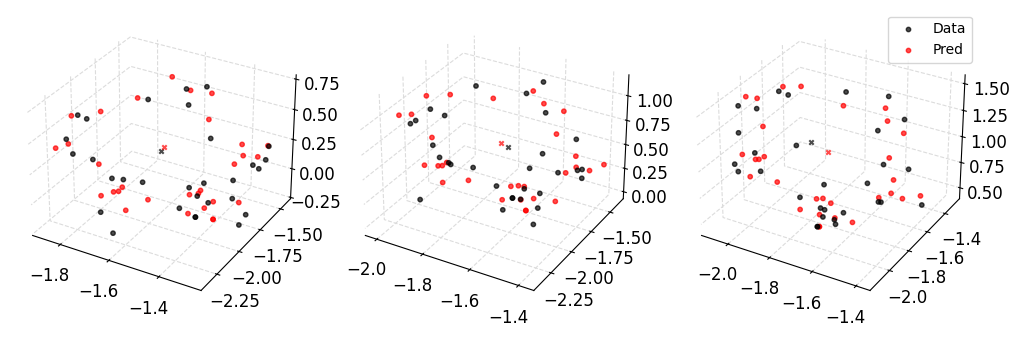

In [12]:
fig, axes = plt.subplots(1, rollout, figsize=(10, 4), subplot_kw={"projection": "3d"})
scatter_kwargs = {"s": 10, "alpha": 0.7}

for i in range(rollout):
    axes[i].scatter(
        *dataset.u[idx_neighbors[0], idx_neighbors[1] + i + 1].T,
        color="black",
        label="Data",
        **scatter_kwargs,
    )
    axes[i].scatter(
        *dataset.u[idx_center[0], idx_center[1] + i + 1].T,
        color="black",
        marker="x",
        **scatter_kwargs,
    )
    axes[i].scatter(
        *(sol[1][i + 1] + sol[0][i + 1]).T, color="red", label="Pred", **scatter_kwargs
    )
    axes[i].scatter(*sol[0][i + 1].T, color="red", marker="x", **scatter_kwargs)
axes[-1].legend(fontsize="small")

In [55]:
sol[1].shape

(4, 30, 3)

In [53]:
sol

(Array([[-1.44618474, -1.8224876 ,  0.01264212],
        [-1.57820262, -1.86654591,  0.33962492],
        [-1.68425164, -1.82547885,  0.68760726],
        [-1.7487154 , -1.68907671,  1.01680325]], dtype=float64),
 Array([[[-0.12542171, -0.34955403, -0.20566692],
         [ 0.22675721,  0.23165992, -0.31128619],
         [-0.13420042, -0.08218134,  0.27741141],
         [-0.20739218, -0.31906127,  0.12253756],
         [ 0.01276799,  0.23164817,  0.3420689 ],
         [-0.13568465, -0.02369887,  0.36789238],
         [ 0.19773396,  0.33762798, -0.02723971],
         [ 0.22053539,  0.2643466 , -0.22167009],
         [ 0.03928586, -0.10046189, -0.31749923],
         [-0.2061545 , -0.41686561, -0.04645133],
         [-0.04763948,  0.09397452,  0.30013215],
         [-0.0505725 ,  0.0885312 ,  0.29511224],
         [-0.08910248, -0.27612106, -0.19713694],
         [-0.04178087, -0.280446  , -0.37755942],
         [-0.05144911,  0.09734137,  0.31093858],
         [-0.24647053, -0.34383643,  

In [4]:
num_neighbors = 10
loader = NeighborhoodSegmentLoader(
    dataset, 2, num_neighbors, RandomSampleBatching(batch_size=2048)
)
loader_state = loader.init()
batch, loader_state = loader.load_batch(loader_state)

In [5]:
dataset.u.shape

(50, 500, 3)

In [6]:
idx_u = 1000

t = batch[0][idx_u]
u = batch[1][idx_u]
u_nn = batch[2][idx_u]
du_nn = u_nn - jnp.expand_dims(u, -2)


tangent_ode = NeuralNeighborhoodFlow(TransformedODE(Lorenz63(), transform))

u_pred, du_nn_pred = solve_ode(
    tangent_ode,
    t,
    (u[0], du_nn[0]),
    rtol=1e-4,
    atol=1e-6,
    max_steps=None,
)
# du_nn_pred = jnp.permute_dims(du_nn_pred, (0, 2, 1))
u_nn_pred1 = jnp.expand_dims(u, -2) + du_nn_pred
u_nn_pred2 = jnp.expand_dims(u_pred, -2) + du_nn_pred

Text(0.5, 0.98, 'Downsample = 2, Noise = 0.0, # neighbors = 30')

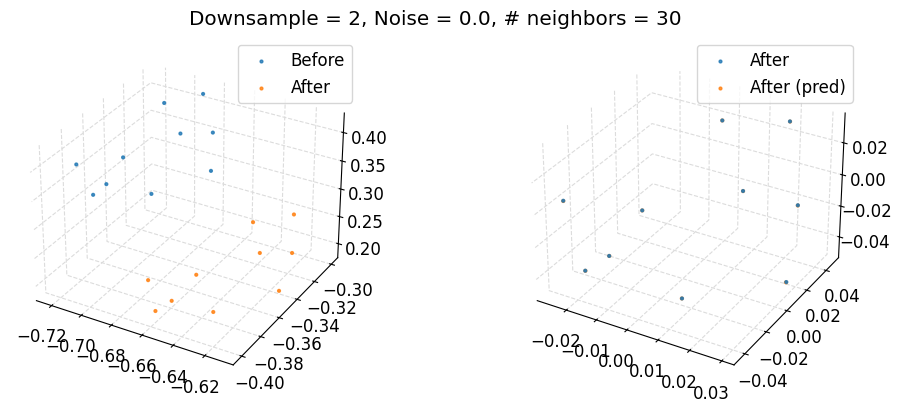

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), subplot_kw={"projection": "3d"})
scatter_kwargs = {"s": 4.0, "alpha": 0.8}
axes[0].scatter(*u_nn[0].T, label="Before", **scatter_kwargs)
axes[0].scatter(*u_nn[1].T, label="After", **scatter_kwargs)

# axes[1].scatter(*u_nn0[1:].T, label="Before", s=2.0, alpha=0.2)
axes[1].scatter(*du_nn[1].T, label="After", **scatter_kwargs)
axes[1].scatter(*du_nn_pred[1].T, label="After (pred)", **scatter_kwargs)
for ax in axes:
    ax.legend()

fig.suptitle(f"Downsample = {downsample}, Noise = {noise}, # neighbors = {30}")
## TODO: Compare how different metrics degrade as a function of noise amplitude
# ex. MSE between neighborhood positions, a more distribution-based metric, normal vectors, etc.

Text(0.5, 0.98, 'Downsample = 10, Noise = 0.01, # neighbors = 30')

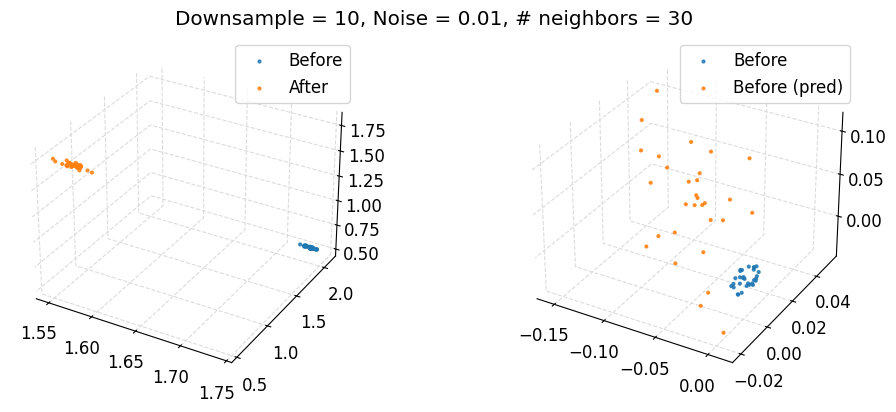

In [18]:
u_pred_inv, du_nn_pred_inv = solve_ode(
    tangent_ode,
    t[::-1],
    (u[1], du_nn[1]),
    rtol=1e-4,
    atol=1e-6,
    max_steps=None,
)
# du_nn_pred = jnp.permute_dims(du_nn_pred, (0, 2, 1))
# u_nn_pred1 = jnp.expand_dims(u, -2) + du_nn_pred
# u_nn_pred2 = jnp.expand_dims(u_pred, -2) + du_nn_pred

fig, axes = plt.subplots(1, 2, figsize=(10, 4), subplot_kw={"projection": "3d"})
scatter_kwargs = {"s": 4.0, "alpha": 0.8}
axes[0].scatter(*u_nn[0].T, label="Before", **scatter_kwargs)
axes[0].scatter(*u_nn[1].T, label="After", **scatter_kwargs)

# axes[1].scatter(*u_nn0[1:].T, label="Before", s=2.0, alpha=0.2)
axes[1].scatter(*du_nn[0].T, label="Before", **scatter_kwargs)
axes[1].scatter(
    *du_nn_pred_inv[1].T,
    label="Before (pred)",
    **scatter_kwargs,
)
for ax in axes:
    ax.legend()

fig.suptitle(f"Downsample = {downsample}, Noise = {noise}, # neighbors = {30}")
## TODO: Compare how different metrics degrade as a function of noise amplitude
# ex. MSE between neighborhood positions, a more distribution-based metric, normal vectors, etc.

In [ ]:
loss_fn = NeighborhoodMSELoss()


@jax.jit
@partial(batched_vmap, batch_size=5, in_axes=(None, 0, 0))
@partial(jax.vmap, in_axes=(None, 0, 0))
def loss_from_params(sigma, beta, rho):
    ode = Lorenz63(sigma, beta, rho)
    model = NeuralNeighborhoodFlow(ODEModel(TransformedODE(ode, transform)))
    return loss_fn(model, batch, None)[1]


beta_grid, rho_grid = jnp.meshgrid(
    jnp.linspace(0, 5.0, 100), jnp.linspace(0.0, 60.0, 100)
)
loss_array = loss_from_params(10.0, beta_grid, rho_grid)

Text(0.5, 0.98, 'Downsample = 40, Noise = 0.0, # neighbors = 10')

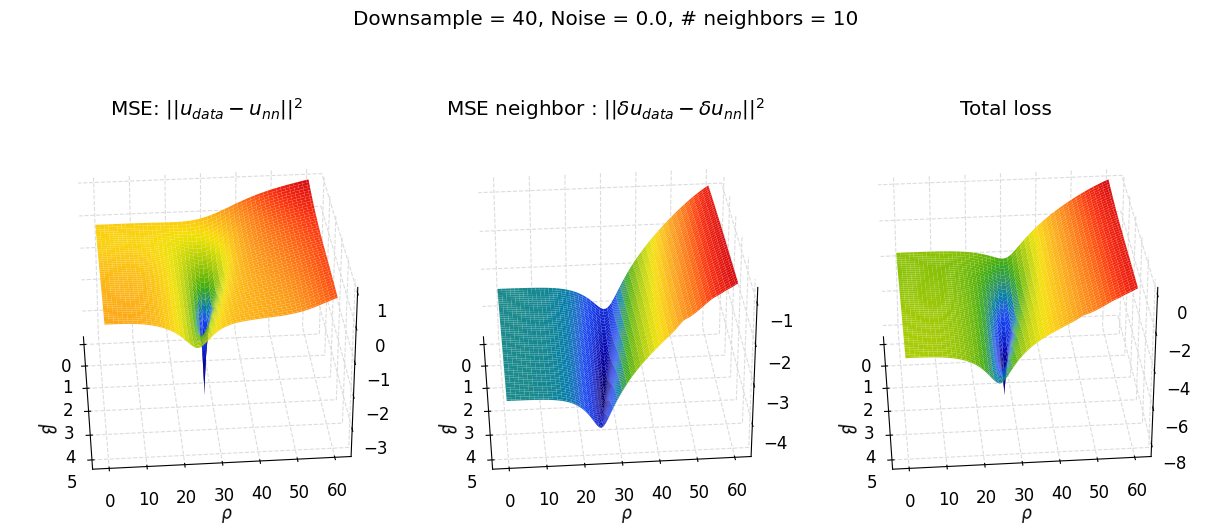

In [ ]:
fig, axes = plt.subplots(
    1, 3, figsize=(12, 6), sharex=True, subplot_kw={"projection": "3d"}
)
values = [
    np.log10(loss_array["mse"]),
    np.log10(loss_array["mse_neighbors"]),
    np.log10(loss_array["mse"]) + np.log10(loss_array["mse_neighbors"]),
]

for ax, v in zip(axes, values):
    plot = ax.plot_surface(
        beta_grid,
        rho_grid,
        v,
        cmap=cc.cm.rainbow4,
    )
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("right", size="5%", pad=0.05, axes_class=plt.Axes)
    # fig.colorbar(plot, cax=cax, orientation="vertical", shrink=0.3)

    ax.view_init(azim=-5)
    ax.set_xlabel(r"$\beta$")
    ax.set_ylabel(r"$\rho$")
axes[0].set_title(r"MSE: $||u_{data}-u_{nn}||^2$")
axes[1].set_title(r"MSE neighbor : $||\delta u_{data}-\delta u_{nn}||^2$")
axes[2].set_title(r"Total loss")

fig.suptitle(
    f"Downsample = {downsample}, Noise = {noise}, # neighbors = {num_neighbors}",
    fontsize="large",
)

In [ ]:
from jaxtyping import PyTree


class NeighborhoodMSELoss2(AbstractDynamicsLoss):
    weight: float = 1.0
    batch_size: int | None = None

    def __call__(
        self,
        model: NeuralNeighborhoodFlow,
        batch: PyTree[Float[Array, "batch ..."]],
        args: Any = None,
        **kwargs: Any,
    ) -> FloatScalar:
        t_data: Float[Array, "batch time_batch"]
        u_data: Float[Array, "batch time_batch dim"]
        u_nn_data: Float[Array, "batch time_batch neighbors dim"]
        # weights: Float[Array, "batch neighbors"]
        # t_data, u_data, du_data, weights = batch
        t_data, u_data, u_nn_data = batch

        batch_size = u_data.shape[0] if self.batch_size is None else self.batch_size
        len_neighbors = u_nn_data.shape[1]

        @partial(batched_vmap, in_axes=(0, 0, 0), batch_size=batch_size)
        def _solve(
            t: Float[Array, " time_batch_neighbors"],
            u0: Float[Array, " dim"],
            du0: Float[Array, " neighbors dim"],
        ):
            return model.solve(
                t,
                (u0, du0),
                **kwargs,
            )

        @partial(batched_vmap, in_axes=(0, 0), batch_size=batch_size)
        def _solve_ode(
            t: Float[Array, " {time_batch-time_batch_neighbors}"],
            u0: Float[Array, " dim"],
        ):
            return model.ode.solve(
                t,
                u0,
                **kwargs,
            )

        du_nn_data = u_nn_data - jnp.expand_dims(u_data, 2)
        u_pred, du_pred = _solve(
            t_data[:, :len_neighbors], u_data[:, 0], du_nn_data[:, 0]
        )

        u_pred_inv, du_pred_inv = _solve(
            t_data[:, 0:len_neighbors][:, ::-1],
            u_data[:, len_neighbors - 1],
            du_nn_data[:, -1],
        )
        # u_nn_pred = jnp.expand_dims(u_pred, 2) + du_pred

        # mse_neighbors = jnp.mean(
        #     jnp.sum(
        #         jnp.mean((u_nn_pred - u_nn_data) ** 2, axis=(1, 3)) * weights, axis=-1
        #     )
        #     # / jnp.clip(
        #     #     jnp.sum(weights, axis=-1), min=1
        #     # )  # Trick do avoid divide by zero
        # )
        # mse_neighbors = jnp.mean((u_nn_pred - u_nn_data) ** 2)
        # mse_neighbors = jnp.mean((du_pred - du_nn_data) ** 2) + jnp.mean(
        #     (du_pred_inv[:, ::-1] - du_nn_data) ** 2
        # )
        # mse_neighbors = jnp.mean((du_pred_inv[:, ::-1] - du_nn_data) ** 2)
        mse_neighbors = jnp.mean((u_pred_inv[:, ::-1] - u_data) ** 2)
        # u_pred_rest = _solve_ode(t_data[:, len_neighbors - 1 :], u_pred[:, -1])
        # u_pred_total = jnp.concatenate((u_pred, u_pred_rest[:, 1:]), axis=1)
        # mse_total = jnp.mean((u_pred_total - u_data) ** 2)
        mse_total = jnp.mean((u_pred - u_data) ** 2)
        return mse_total + self.weight * mse_neighbors, {
            "mse": mse_total,
            "mse_neighbors": mse_neighbors,
        }

        # return (mse_total + n_neighbors * mse_neighbors) / (n_neighbors + 1), {
        #     "mse": mse_total,
        #     "mse_neighbors": mse_neighbors,
        # }

Text(0.5, 0.98, 'Downsample = 10, Noise = 0.01, # neighbors = 30')

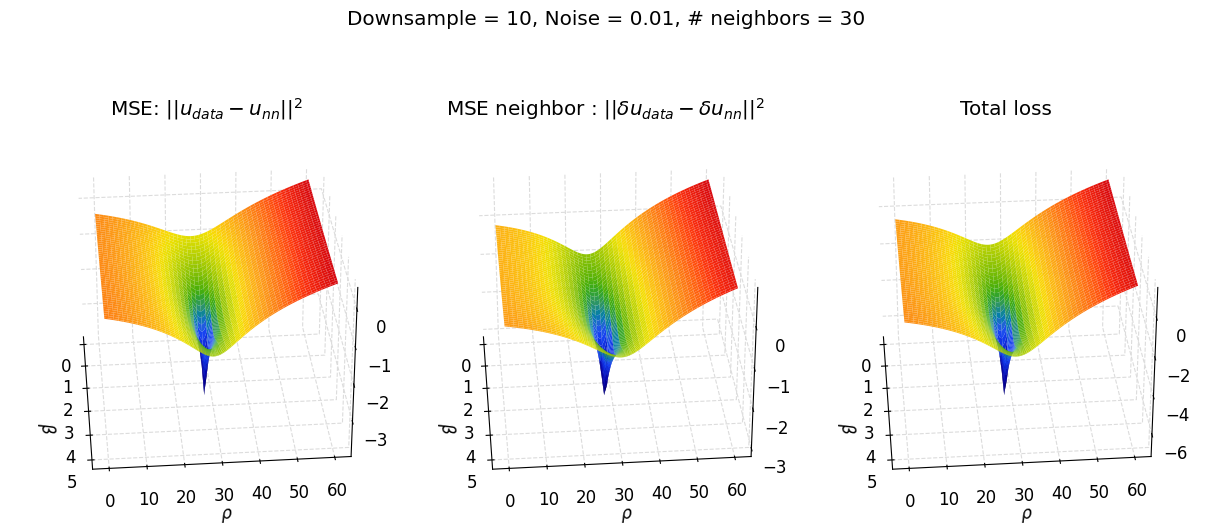

In [ ]:
loss_fn = NeighborhoodMSELoss2()


@jax.jit
@partial(batched_vmap, batch_size=5, in_axes=(None, 0, 0))
@partial(jax.vmap, in_axes=(None, 0, 0))
def loss_from_params(sigma, beta, rho):
    ode = Lorenz63(sigma, beta, rho)
    model = NeuralNeighborhoodFlow(ODEModel(TransformedODE(ode, transform)))
    return loss_fn(model, batch, None)[1]


beta_grid, rho_grid = jnp.meshgrid(
    jnp.linspace(0, 5.0, 100), jnp.linspace(0.0, 60.0, 100)
)
loss_array = loss_from_params(10.0, beta_grid, rho_grid)


fig, axes = plt.subplots(
    1, 3, figsize=(12, 6), sharex=True, subplot_kw={"projection": "3d"}
)
values = [
    np.log10(loss_array["mse"]),
    np.log10(loss_array["mse_neighbors"]),
    np.log10(loss_array["mse"]) + np.log10(loss_array["mse_neighbors"]),
]

for ax, v in zip(axes, values):
    plot = ax.plot_surface(
        beta_grid,
        rho_grid,
        v,
        cmap=cc.cm.rainbow4,
    )
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("right", size="5%", pad=0.05, axes_class=plt.Axes)
    # fig.colorbar(plot, cax=cax, orientation="vertical", shrink=0.3)

    ax.view_init(azim=-5)
    ax.set_xlabel(r"$\beta$")
    ax.set_ylabel(r"$\rho$")
axes[0].set_title(r"MSE: $||u_{data}-u_{nn}||^2$")
axes[1].set_title(r"MSE neighbor : $||\delta u_{data}-\delta u_{nn}||^2$")
axes[2].set_title(r"Total loss")

fig.suptitle(
    f"Downsample = {downsample}, Noise = {noise}, # neighbors = 30", fontsize="large"
)

In [7]:
from dynamics_discovery.loss_functions import JacobianMatchingMSE


loss_fn2 = JacobianMatchingMSE(TransformedODE(Lorenz63(), transform))


@jax.jit
@partial(jax.vmap, in_axes=(None, 0, 0))
@partial(jax.vmap, in_axes=(None, 0, 0))
def loss_from_params2(sigma, beta, rho):
    ode = Lorenz63(sigma, beta, rho)
    model = ODEModel(TransformedODE(ode, transform))
    return loss_fn2(model, batch[0:2], None)[1]


beta_grid, rho_grid = jnp.meshgrid(
    jnp.linspace(0, 5.0, 100), jnp.linspace(0.0, 60.0, 100)
)

beta_array = jnp.linspace(0, 5.0, 50)
rho_array = jnp.linspace(0.0, 60.0, 50)

In [8]:
loss_array2 = loss_from_params2(10.0, beta_grid, rho_grid)

Text(0.5, 0.98, 'Downsample = 40, Noise = 0.0')

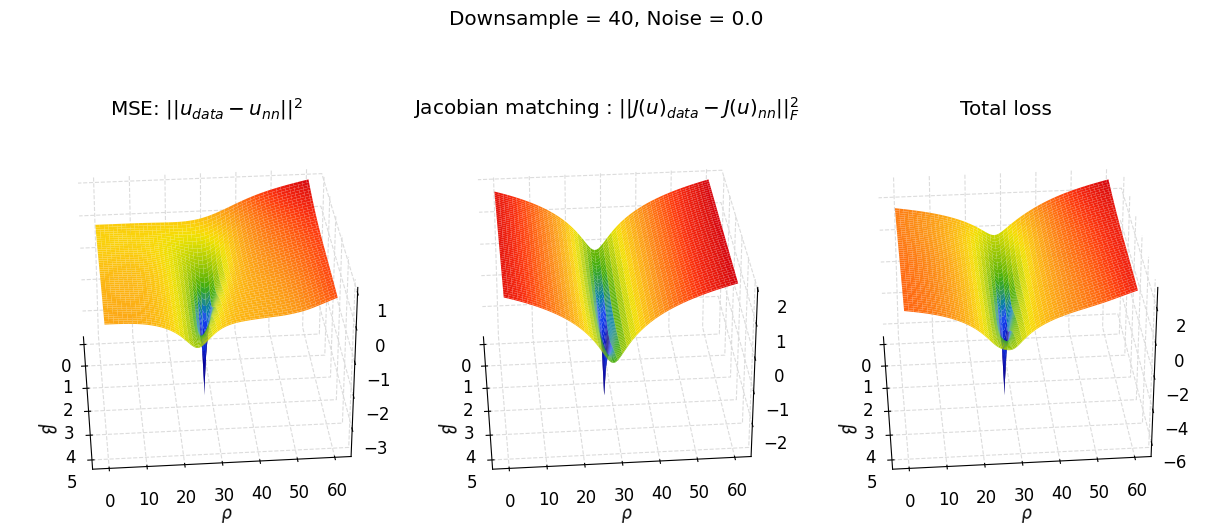

In [9]:
fig, axes = plt.subplots(
    1, 3, figsize=(12, 6), sharex=True, subplot_kw={"projection": "3d"}
)
values = [
    np.log10(loss_array2["mse"]),
    np.log10(loss_array2["jac_loss"]),
    np.log10(loss_array2["mse"]) + np.log10(loss_array2["jac_loss"]),
]

for ax, v in zip(axes, values):
    plot = ax.plot_surface(
        beta_grid,
        rho_grid,
        v,
        cmap=cc.cm.rainbow4,
    )
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("right", size="5%", pad=0.05, axes_class=plt.Axes)
    # fig.colorbar(plot, cax=cax, orientation="vertical", shrink=0.3)

    ax.view_init(azim=-5)
    ax.set_xlabel(r"$\beta$")
    ax.set_ylabel(r"$\rho$")
axes[0].set_title(r"MSE: $||u_{data}-u_{nn}||^2$")
axes[1].set_title(r"Jacobian matching : $||J(u)_{data}-J(u)_{nn}||_F^2$")
axes[2].set_title(r"Total loss")
fig.suptitle(f"Downsample = {downsample}, Noise = {noise}", fontsize="large")

In [5]:
loader_state[0][0].shape

(1245000,)

In [3]:
def tangent_evolution_matrix(
    ode: AbstractODE,
    x: Float[Array, " dim"],
    t0: float,
    t1: float,
    solver: dfx.AbstractAdaptiveSolver = dfx.Tsit5(),
    stepsize_controller: dfx.AbstractAdaptiveStepSizeController = dfx.PIDController(
        rtol=1e-4, atol=1e-6
    ),
):
    tangent_ode = TangentODE(ode)
    u0 = (x, jnp.identity(ode.dim))

    sol = dfx.diffeqsolve(
        dfx.ODETerm(tangent_ode.rhs),
        solver,
        t0,
        t1,
        None,
        u0,
        None,
        saveat=dfx.SaveAt(t1=True),
        stepsize_controller=stepsize_controller,
    )
    _, M_t = sol.ys
    return M_t[0]  # remove time dimension


class TangentEvolutionMatchingMSE(AbstractDynamicsLoss):
    ode_true: AbstractODE
    weight: float
    batch_size: int | None

    def __init__(
        self,
        ode_true: AbstractODE,
        weight: float = 1.0,
        batch_size: int | None = None,
    ):
        self.ode_true = ode_true
        self.weight = weight
        self.batch_size = batch_size

    def __call__(
        self,
        model: AbstractDynamicsModel,
        batch: PyTree[Float[Array, "batch ..."]],
        args: Any = None,
        **kwargs: Any,
    ) -> FloatScalar:
        t_data, u_data = batch

        batch_size = u_data.shape[0] if self.batch_size is None else self.batch_size

        @partial(batched_vmap, in_axes=(0, 0), batch_size=batch_size)
        def _mse(t_data_: Float[Array, " time"], u_data_):
            u_pred = model.solve(t_data_, u_data_[0], args, **kwargs)
            return jnp.mean((u_pred - u_data_) ** 2)

        @partial(batched_vmap, in_axes=(0, 0), batch_size=batch_size)
        def _tangent_evol_loss(t_data_: Float[Array, " time"], u_data_):
            evol_pred = tangent_evolution_matrix(
                model,
                u_data_[0],
                t_data_[0],
                t_data_[-1],
                model.solver,
                model.stepsize_controller,
            )
            evol_true = tangent_evolution_matrix(
                self.ode_true,
                u_data_[0],
                t_data_[0],
                t_data_[-1],
                model.solver,
                model.stepsize_controller,
            )
            return jnp.mean((evol_pred - evol_true) ** 2)

        mse_total = jnp.mean(_mse(t_data, u_data))
        evol_loss_total = jnp.mean(_tangent_evol_loss(t_data, u_data))
        return mse_total + self.weight * evol_loss_total, {
            "mse": mse_total,
            "tangent_evolution_loss": evol_loss_total,
        }

In [4]:
loss_fn3 = TangentEvolutionMatchingMSE(TransformedODE(Lorenz63(), transform))


@jax.jit
@partial(batched_vmap, batch_size=5, in_axes=(None, 0, 0))
@partial(jax.vmap, in_axes=(None, 0, 0))
def loss_from_params3(sigma, beta, rho):
    ode = Lorenz63(sigma, beta, rho)
    model = ODEModel(TransformedODE(ode, transform))
    return loss_fn3(model, batch[0:2], None)[1]


beta_grid, rho_grid = jnp.meshgrid(
    jnp.linspace(0, 5.0, 100), jnp.linspace(0.0, 60.0, 100)
)

beta_array = jnp.linspace(0, 5.0, 50)
rho_array = jnp.linspace(0.0, 60.0, 50)

In [7]:
loss_array3 = loss_from_params3(10.0, beta_grid, rho_grid)

Text(0.5, 0.98, 'Downsample = 5, Noise = 0.0')

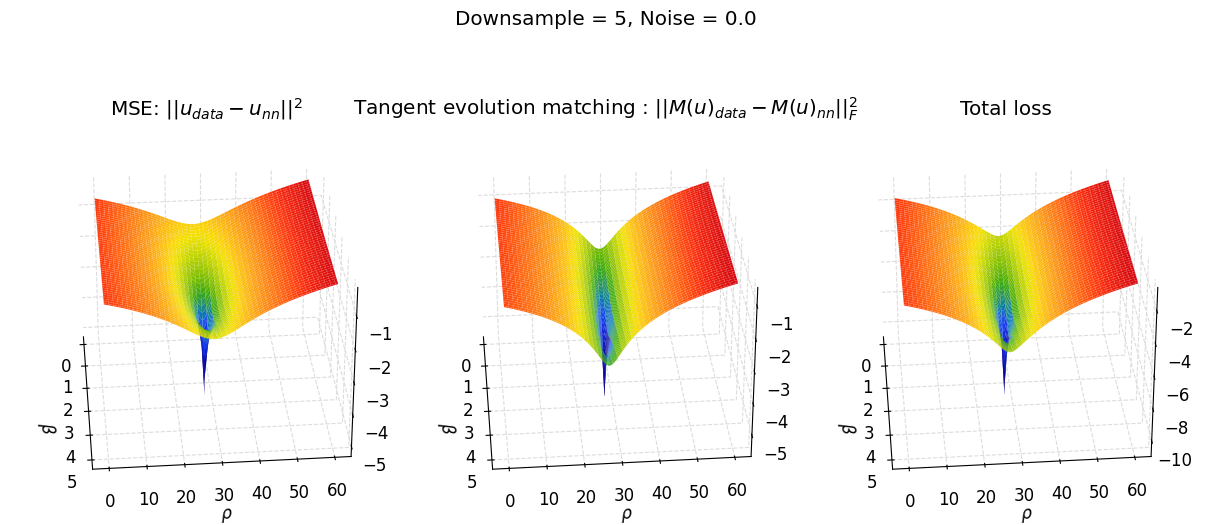

In [8]:
fig, axes = plt.subplots(
    1, 3, figsize=(12, 6), sharex=True, subplot_kw={"projection": "3d"}
)
values = [
    np.log10(loss_array3["mse"]),
    np.log10(loss_array3["tangent_evolution_loss"]),
    np.log10(loss_array3["mse"]) + np.log10(loss_array3["tangent_evolution_loss"]),
]

for ax, v in zip(axes, values):
    plot = ax.plot_surface(
        beta_grid,
        rho_grid,
        v,
        cmap=cc.cm.rainbow4,
    )
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("right", size="5%", pad=0.05, axes_class=plt.Axes)
    # fig.colorbar(plot, cax=cax, orientation="vertical", shrink=0.3)

    ax.view_init(azim=-5)
    ax.set_xlabel(r"$\beta$")
    ax.set_ylabel(r"$\rho$")
axes[0].set_title(r"MSE: $||u_{data}-u_{nn}||^2$")
axes[1].set_title(r"Tangent evolution matching : $||M(u)_{data}-M(u)_{nn}||_F^2$")
axes[2].set_title(r"Total loss")
fig.suptitle(f"Downsample = {downsample}, Noise = {noise}", fontsize="large")

## Prototype implementing the ConFIG method

In [ ]:
from dynamics_discovery.training.multiterm import filter_value_and_grad_ConFIG


loss_fn_multi = NeighborhoodMSELoss(multiterm=True)
model = NeuralNeighborhoodFlow(NeuralODE(3, 32, 3))

num_neighbors = 10
loader = NeighborhoodSegmentLoader(
    dataset, 2, num_neighbors, RandomSampleBatching(batch_size=2048)
)
loader_state = loader.init()
batch, loader_state = loader.load_batch(loader_state)

In [ ]:
config_grad_fn = filter_value_and_grad_ConFIG(loss_fn_multi, has_aux=True)

In [96]:
(loss, aux), grad_config = config_grad_fn(model, batch)
print(loss)
print(aux)
print(grad_config)

1.0615665930098708
{'mse': Array(1.06110904, dtype=float64), 'mse_neighbors': Array(0.00045755, dtype=float64)}
NeuralNeighborhoodFlow(
  ode=NeuralODE(
    net=MLP(
      layers=(
        Linear(
          weight=f64[32,3],
          bias=f64[32],
          in_features=3,
          out_features=32,
          use_bias=True
        ),
        Linear(
          weight=f64[32,32],
          bias=f64[32],
          in_features=32,
          out_features=32,
          use_bias=True
        ),
        Linear(
          weight=f64[32,32],
          bias=f64[32],
          in_features=32,
          out_features=32,
          use_bias=True
        ),
        Linear(
          weight=f64[3,32],
          bias=f64[3],
          in_features=32,
          out_features=3,
          use_bias=True
        )
      ),
      activation=None,
      final_activation=None,
      use_bias=True,
      use_final_bias=True,
      in_size=3,
      out_size=3,
      width_size=32,
      depth=3
    ),
    dim=3,


In [3]:
import numpy as np
from tqdm import tqdm


loader = NeighborhoodSegmentLoader(
    dataset,
    2,
    30,
    MiniBatching(batch_size=10000, permute_initial=False, drop_last=False),
)
loader_state = loader.init()

u_neighbors = []
for i in tqdm(range(loader.num_batches)):
    batch, loader_state = loader.load_batch(loader_state)
    u_neighbors.append(np.asarray(batch[2]))

100%|██████████| 125/125 [00:32<00:00,  3.84it/s]


In [6]:
u_neighbors[-2].shape

(10000, 2, 30, 3)

In [4]:
loader = NeighborhoodSegmentLoader(dataset, 2, 30, MiniBatching(batch_size=10000))
loader_state = loader.init()
loader_state

((Array([2052612, 4922476, 3295904, ...,  823700, 3925540, 1025065], dtype=int64),
  0,
  Array((), dtype=key<fry>) overlaying:
  [1797259609 2579123966]),)

In [5]:
jax.random.permutation(jax.random.key(0), 5)

Array([0, 1, 4, 3, 2], dtype=int64)

In [4]:
M_pred = eqx.filter_vmap(
    lambda u_i: tangent_evolution_matrix(
        lorenz_scaled, u_i, 0.0, t_train[n_steps - 1] - t_train[0]
    )
)(u_train[: -n_steps + 1])

In [5]:
import scipy.signal as scsignal


u_smooth = scsignal.savgol_filter(u_train, window_length=7, polyorder=3, axis=0)
u_smooth.shape

(10000, 3)

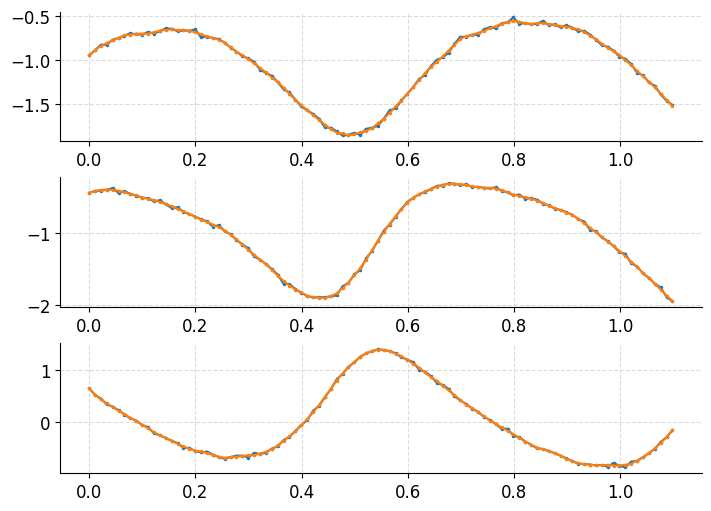

In [6]:
fig, axes = plt.subplots(3, 1, figsize=(7, 5))
for i, ax in enumerate(axes):
    ax.plot(t_train[:100], u_train[:100, i], ".-")
    ax.plot(t_train[:100], u_smooth[:100, i], ".-")

In [7]:
_, _, du, _ = create_neighborhood_dataset(
    t_train,
    u_smooth,
    num_neighbors=30,
    train_length=n_steps,
    train_length_neighbors=n_steps,
    min_radius=0.2,
    max_radius=0.4,
)

In [8]:
du.shape

(9999, 2, 30, 3)

In [9]:
du0, du1 = du[:, 0], du[:, -1]

M_data = jnp.permute_dims((jnp.linalg.pinv(du0) @ du1).T, (2, 0, 1))

In [10]:
du0_test = du0[0]
du0_test.shape

(30, 3)

In [11]:
import itertools


def batched_outer(
    x: Float[Array, "*dims_x"], y: Float[Array, " dim_y"]
) -> Float[Array, "*dims_x dim_y"]:
    """Compute a (batched) outer product between a n(>1)D tensor x and a 1D tensor y.

    For x of shape (i_0, ..., i_{n-1}) and y of shape (j,), the output tensor has the
    shape (i_0, ..., i_{n-1}, j)."""
    return jnp.expand_dims(x, axis=-1) * y


def monomial_basis_unique(x, order: int):
    arr = jnp.asarray(list(itertools.combinations_with_replacement(x, order)))
    return jnp.prod(arr, axis=-1)


def make_monomial_features(x, max_order: int = 2):
    """Given a vector x=[x1,x2,x3], create a 1D vector containing all the monomial
    basis terms upto order n.

    For n=2, this corresponds to [x1, x2, x3, x1^2, x1x2, x1x3, x2x1, x2^2, x2x3, x3x1,
    x3x2, x3^2]"""
    terms = [monomial_basis_unique(x, i) for i in range(1, max_order + 1)]
    return jnp.concatenate(terms)

In [12]:
du0_second_order = jax.vmap(jax.vmap(lambda x: make_monomial_features(x, 3)))(du0)
du0_second_order.shape

(9999, 30, 19)

In [13]:
du0_second_order[0, 0]

Array([ 1.15314194e-01,  1.57277650e-01, -4.86175360e-02,  1.32973634e-02,
        1.81363455e-02, -5.60629199e-03,  2.47362592e-02, -7.64645181e-03,
        2.36366481e-03,  1.53337475e-03,  2.09137807e-03, -6.46485044e-04,
        2.85244180e-03, -8.81744430e-04,  2.72564103e-04,  3.89046072e-03,
       -1.20261597e-03,  3.71751646e-04, -1.14915559e-04], dtype=float64)

In [14]:
M_data2 = jnp.permute_dims((jnp.linalg.pinv(du0_second_order) @ du1).T, (2, 0, 1))[
    ..., :3
]
M_data2.shape

(9999, 3, 3)

In [15]:
err = jnp.linalg.norm(M_pred - M_data, axis=(-1, -2)) / jnp.linalg.norm(
    M_pred, axis=(-1, -2)
)
err2 = jnp.linalg.norm(M_pred - M_data2, axis=(-1, -2)) / jnp.linalg.norm(
    M_pred, axis=(-1, -2)
)

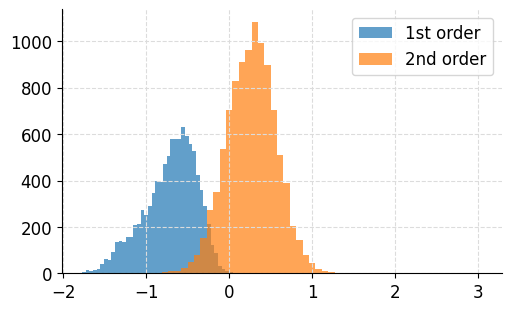

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.hist(jnp.log10(err), bins=50, alpha=0.7, label="1st order")
ax.hist(jnp.log10(err2), bins=50, alpha=0.7, label="2nd order")
ax.legend()

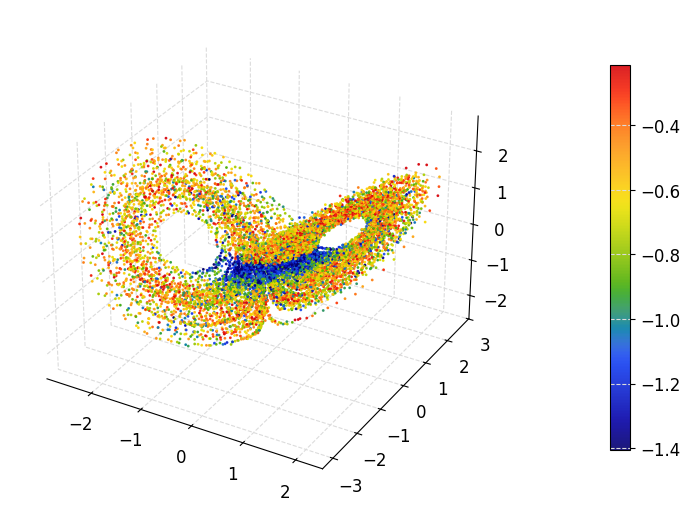

In [17]:
import colorcet as cc
import numpy as np


scatter_kwargs = {
    "s": 1,
    "cmap": cc.cm.rainbow4,
    "vmin": np.percentile(jnp.log10(err), 2.5),
    "vmax": np.percentile(jnp.log10(err), 97.5),
    "alpha": 0.9,
}

fig = colored_scatterplot(
    (u_train[: -n_steps + 1].T,), (jnp.log10(err),), **scatter_kwargs
)

In [ ]:
ode = NeuralODE(3, 32, 3, key=0, solver=dfx.Tsit5(), rtol=1e-4, atol=1e-6)
model = NeuralNeighborhoodFlow(ode, use_seminorm=False, second_order=False)

SyntaxError: positional argument follows keyword argument (2378072622.py, line 1)